Importing nessacry libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tkinter as tk
from tkinter import messagebox
import joblib



Loading And Merging the datasets 

In [2]:
# Load datasets
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

# Add a label column
fake_df['label'] = 0  
true_df['label'] = 1  

#shapes
print("Fake News Shape:", fake_df.shape)
print("True News Shape:", true_df.shape)

# Combine and shuffle
data = pd.concat([fake_df, true_df], axis=0).sample(frac=1).reset_index(drop=True)


Fake News Shape: (23481, 5)
True News Shape: (21417, 5)


In [3]:
data.head()

,title,text,subject,date,label
0,Trump's pick for envoy to Israel expects embas...,WASHINGTON (Reuters) - President-elect Donald ...,politicsNews,"December 16, 2016",1
1,"AMERICANS FURIOUS, Lash Out After Liberals Use...",The One World Trade Center Twitter account ann...,left-news,"Jun 3, 2017",0
2,Minnesota governor's veto of legislative fundi...,(Reuters) - Minnesota Governor Mark Dayton’s M...,politicsNews,"July 19, 2017",1
3,"CNN HOSTS PANIC When Congressman, Lawyer Says ...","Caller-Times: Speaking on CNN Wednesday, the f...",left-news,"May 25, 2017",0
4,Myanmar bars U.N. rights investigator before v...,GENEVA (Reuters) - The U.N. independent invest...,worldnews,"December 20, 2017",1


In [4]:
print('Total Number of fake news : ',data[data['label']== 0].shape[0])
print('Total Number of true news : ',data[data['label']== 1].shape[0])

Total Number of fake news :  23481
Total Number of true news :  21417


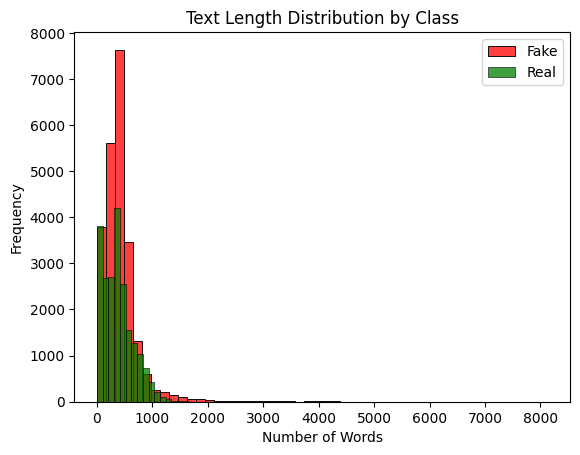

In [5]:
#plotting text lenght for both fake and true news
data['text_length'] = data['text'].apply(lambda x: len(str(x).split()))

sns.histplot(data[data['label']==0]['text_length'], bins=50, color='red', label='Fake', kde=False)
sns.histplot(data[data['label']==1]['text_length'], bins=50, color='green', label='Real', kde=False )
plt.legend()
plt.title("Text Length Distribution by Class")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [6]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

data['cleaned_text'] = data['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to C:\Users\Inshal
[nltk_data]     Munaf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Inshal
[nltk_data]     Munaf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
data.head()

,title,text,subject,date,label,cleaned_text
0,Alec Baldwin Just Put Trump’s Idiot Supporter...,Saturday Night Live returned with a stellar co...,News,"April 9, 2017",0,saturday night live returned stellar cold open...
1,Tokyo Governor Koike: No need for big change i...,"TOKYO (Reuters) - Tokyo Governor Yuriko Koike,...",worldnews,"October 6, 2017",1,tokyo reuters tokyo governor yuriko koike whos...
2,WATCH Huge Crowd Of Muslims Admit That ALL Mus...,https://www.youtube.com/watch?v=8Mehk5eWcZA,left-news,"Feb 8, 2017",0,httpswwwyoutubecomwatchv8mehk5ewcza
3,Vietnam orders prosecution of oil firm officia...,HANOI (Reuters) - Vietnamese police have order...,worldnews,"December 19, 2017",1,hanoi reuters vietnamese police ordered prosec...
4,Maine’s Governor Refuses To Answer One Simple...,The Rachel Maddow Show attempted to reach out ...,News,"January 26, 2016",0,rachel maddow show attempted reach maine gover...


C:\Users\Inshal Munaf\AppData\Local\Temp\ipykernel_20636\2240357418.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


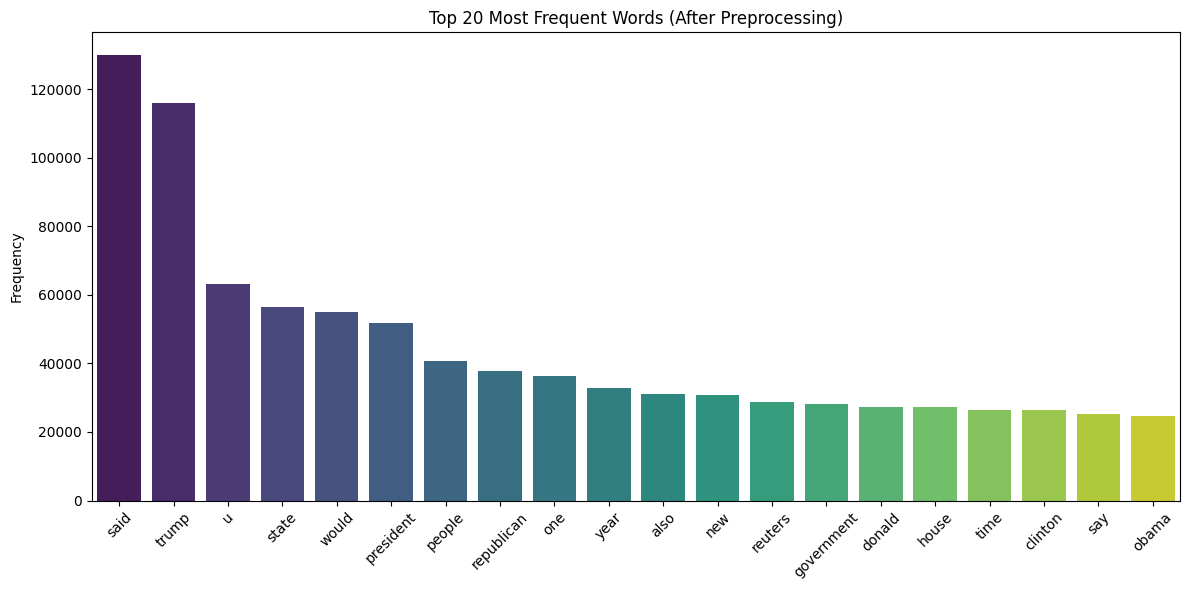

In [9]:
from collections import Counter

all_words = ' '.join(data['cleaned_text']).split()

word_counts = Counter(all_words)

top_words = word_counts.most_common(20)

words, counts = zip(*top_words)

# Plotting
plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts), palette="viridis")
plt.title("Top 20 Most Frequent Words (After Preprocessing)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Inshal Munaf\AppData\Local\Temp\ipykernel_20636\3917005525.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(fake_words), y=list(fake_counts), palette='Reds_r')
C:\Users\Inshal Munaf\AppData\Local\Temp\ipykernel_20636\3917005525.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(real_words), y=list(real_counts), palette='Greens_r')


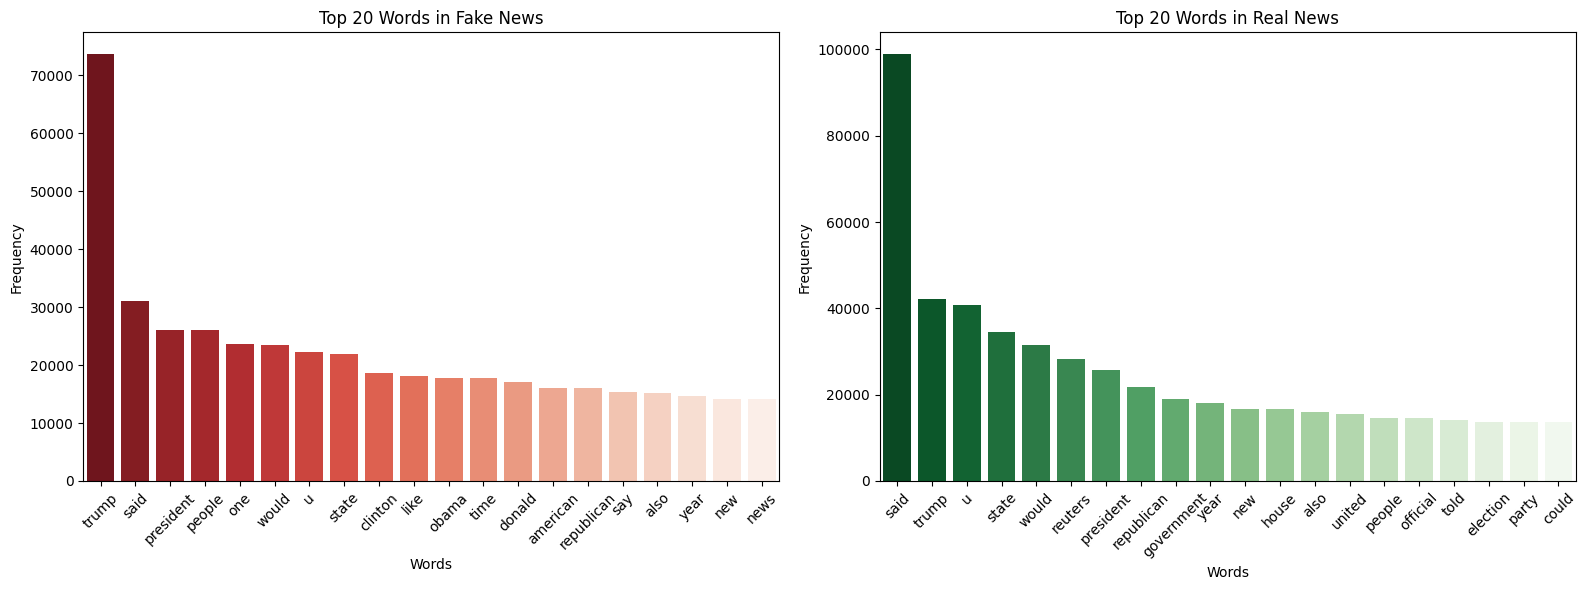

In [8]:
def get_top_words(text_series, top_n=20):
    all_words = ' '.join(text_series).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

top_fake = get_top_words(data[data['label'] == 0]['cleaned_text'], 20)
top_real = get_top_words(data[data['label'] == 1]['cleaned_text'], 20)

fake_words, fake_counts = zip(*top_fake)
real_words, real_counts = zip(*top_real)


plt.figure(figsize=(16, 6))

# Fake News plotting
plt.subplot(1, 2, 1)
sns.barplot(x=list(fake_words), y=list(fake_counts), palette='Reds_r')
plt.title("Top 20 Words in Fake News")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.xlabel("Words")

# Real News plotting
plt.subplot(1, 2, 2)
sns.barplot(x=list(real_words), y=list(real_counts), palette='Greens_r')
plt.title("Top 20 Words in Real News")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.xlabel("Words")

plt.tight_layout()
plt.show()

Converting the text into vectors

In [10]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['cleaned_text']).toarray()
y = data['label']


Splitting the data 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
print("Lenght of X _train : ",len(X_train))
print("Lenght of Y _train : ",len(y_train))
print("Lenght of X _test : ",len(X_test))
print("Lenght of Y _test : ",len(y_test))

Lenght of X _train :  35918
Lenght of Y _train :  35918
Lenght of X _test :  8980
Lenght of Y _test :  8980


Training the model (Logistic)

In [13]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)


Training the model (NaiveBayes)

In [14]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)


Saving the Model

In [20]:
# Save trained Logistic Regression or Naive Bayes model
joblib.dump(log_model, 'logistic_model.pkl')
joblib.dump(nb_model, 'Naive_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

Model Evaluation

In [15]:
def evaluate_model(y_true, y_pred, name):
    print(f"--- {name} Evaluation ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

evaluate_model(y_test, log_preds, "Logistic Regression")
evaluate_model(y_test, nb_preds, "Naive Bayes")


--- Logistic Regression Evaluation ---
Accuracy: 0.9897550111358575
Confusion Matrix:
 [[4543   58]
 [  34 4345]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4601
           1       0.99      0.99      0.99      4379

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

--- Naive Bayes Evaluation ---
Accuracy: 0.9472160356347439
Confusion Matrix:
 [[4329  272]
 [ 202 4177]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      4601
           1       0.94      0.95      0.95      4379

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



Confusion Matrix ---> Logistic Regression

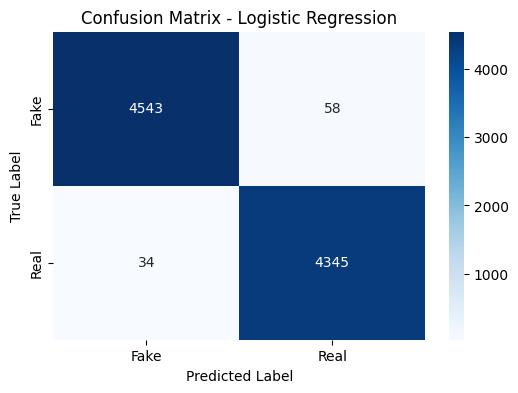

In [16]:

cm_log = confusion_matrix(y_test, log_preds)

# Plotting
plt.figure(figsize=(6,4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

Confusion Matrix ---> Naive Bayes

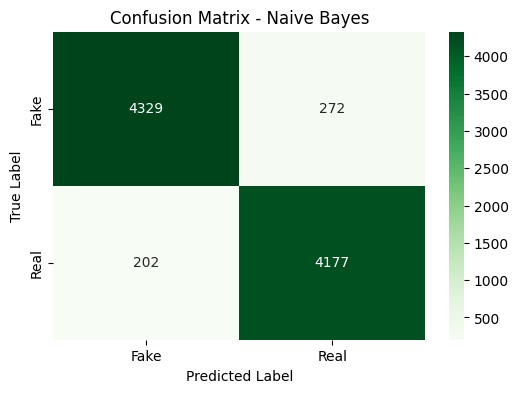

In [17]:

cm_nb = confusion_matrix(y_test, nb_preds)

# Plotting
plt.figure(figsize=(6,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

LSTM MODEL

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Use cleaned_text column directly
X_text_lstm = data['cleaned_text']
y_lstm = data['label']

# Tokenize the text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_text_lstm)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(X_text_lstm)

# Pad sequences
X_pad = pad_sequences(sequences, maxlen=300)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)


Build And Training the LSTM Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=300))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


c:\Users\Inshal Munaf\VsCodeProjects\fake_news\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Training
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 147s 290ms/step - accuracy: 0.9799 - loss: 0.0682 - val_accuracy: 0.9891 - val_loss: 0.0427
Epoch 2/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 144s 283ms/step - accuracy: 0.9775 - loss: 0.0722 - val_accuracy: 0.9936 - val_loss: 0.0264
Epoch 3/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 142s 281ms/step - accuracy: 0.9856 - loss: 0.0446 - val_accuracy: 0.9535 - val_loss: 0.1340
Epoch 4/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 143s 282ms/step - accuracy: 0.9700 - loss: 0.0963 - val_accuracy: 0.9791 - val_loss: 0.0788
Epoch 5/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 141s 278ms/step - accuracy: 0.9898 - loss: 0.0401 - val_accuracy: 0.9897 - val_loss: 0.0399


Evaluating LSTM Model

In [25]:

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step
[[4536   65]
 [  45 4334]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4601
           1       0.99      0.99      0.99      4379

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



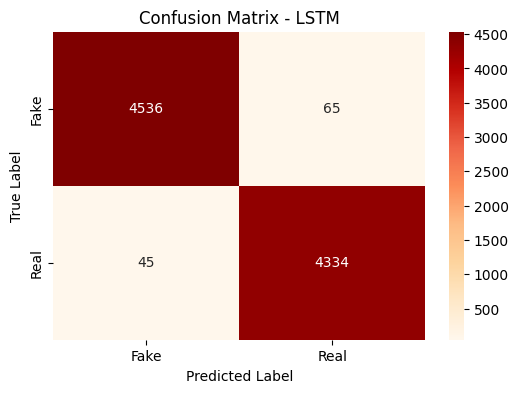

In [32]:
cm_nb = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(6,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='OrRd', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM")
plt.show()

Saving the LST Model

In [33]:
model.save("lstm_fake_news_model.h5")

Saving Tokenizer

In [34]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [47]:
import tkinter as tk
from tkinter import ttk, scrolledtext, messagebox
import joblib
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Load models and vectorizer/tokenizer
try:
    logistic_model = joblib.load('logistic_model.pkl')
    naive_model = joblib.load('Naive_model.pkl')
    tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
    lstm_model = load_model('lstm_fake_news_model.h5')
    tokenizer = joblib.load('tokenizer.pkl')
except Exception as e:
    messagebox.showerror("Error", f"Cannot load models: {e}")
    exit()

# Preprocessing function (matches training)
def clean_text(text):
    text = str(text).lower()  
    text = text.translate(str.maketrans('', '', string.punctuation))  
    words = text.split() 
    stop_words = set(stopwords.words('english'))
    words = [WordNetLemmatizer().lemmatize(word) for word in words if word not in stop_words]  
    return ' '.join(words)  

# Prediction function
def predict_news():
    news_text = text_input.get("1.0", tk.END).strip()
    if not news_text:
        result_label.config(text="Please enter a news article.", foreground="red")
        return

    predict_button.config(state="disabled")
    result_label.config(text="Processing...", foreground="blue")
    root.update()

    try:
        cleaned_text = clean_text(news_text)
        if not cleaned_text:
            raise Exception("Text processing failed.")

        model_choice = model_var.get()
        if model_choice in ["Logistic Regression", "Naive Bayes"]:
            # Vectorize for Logistic Regression or Naive Bayes
            vectorized_text = tfidf_vectorizer.transform([cleaned_text])
            if model_choice == "Logistic Regression":
                prediction = logistic_model.predict(vectorized_text)[0]
                prob = logistic_model.predict_proba(vectorized_text)[0]
            else:
                prediction = naive_model.predict(vectorized_text)[0]
                prob = naive_model.predict_proba(vectorized_text)[0]
            result = "Real" if prediction == 1 else "Fake"
            confidence = max(prob) * 100
        else:  # LSTM
            # Tokenize and pad for LSTM
            sequence = tokenizer.texts_to_sequences([cleaned_text])
            padded_sequence = pad_sequences(sequence, maxlen=300, padding='post', truncating='post')
            prediction = lstm_model.predict(padded_sequence, verbose=0)[0][0]
            result = "Real" if prediction >= 0.5 else "Fake"
            confidence = prediction * 100 if result == "Real" else (1 - prediction) * 100

        result_label.config(
            text=f"Prediction: {result}\nConfidence: {confidence:.2f}%",
            foreground="green" if result == "Real" else "red"
        )
    except Exception as e:
        messagebox.showerror("Error", f"Prediction failed: {e}")
        result_label.config(text="Prediction failed.", foreground="red")
    finally:
        predict_button.config(state="normal")

# Reset function
def reset_text():
    text_input.delete("1.0", tk.END)
    result_label.config(text="Prediction will appear here.", foreground="black")
    predict_button.config(state="normal")

# Create main window
root = tk.Tk()
root.title("Fake News Predictor")
root.geometry("600x400")
root.configure(bg="#1E3A8A")  

# Style settings
style = ttk.Style()
style.theme_use("clam")
style.configure("TButton", background="#3B82F6", foreground="white", font=("Arial", 12, "bold"), padding=10)
style.map("TButton", background=[("active", "#2563EB")])
style.configure("TLabel", background="#1E3A8A", foreground="white", font=("Arial", 12))
style.configure("TCombobox", fieldbackground="#BFDBFE", background="#3B82F6", foreground="black")

# Title
title_label = ttk.Label(root, text="Fake News Predictor", font=("Arial", 20, "bold"))
title_label.pack(pady=10)

# Model selection
model_var = tk.StringVar(value="Logistic Regression")
model_label = ttk.Label(root, text="Choose Model:")
model_label.pack()
model_menu = ttk.Combobox(root, textvariable=model_var, values=["Logistic Regression", "Naive Bayes", "LSTM"], state="readonly")
model_menu.pack(pady=5)

# Text input
input_label = ttk.Label(root, text="Enter News Article:")
input_label.pack()
text_input = scrolledtext.ScrolledText(root, height=8, width=50, bg="#BFDBFE", fg="black", font=("Arial", 11))
text_input.pack(pady=10)

# Buttons
button_frame = tk.Frame(root, bg="#1E3A8A")
button_frame.pack(pady=10)
predict_button = ttk.Button(button_frame, text="Predict", command=predict_news)
predict_button.pack(side=tk.LEFT, padx=5)
reset_button = ttk.Button(button_frame, text="Reset", command=reset_text)
reset_button.pack(side=tk.LEFT, padx=5)

# Result display
result_label = ttk.Label(root, text="Prediction will appear here.", font=("Arial", 14))
result_label.pack(pady=10)


root.mainloop()